In [16]:
from dreal import *
import numpy as np
import torch 
x = torch.FloatTensor(3,2).uniform_(-1,1)
xe = np.array([[2,3],[3,4],[5,6]])
ball_in_bound = logical_and(1.0 <= 2.0, 1.0 <= 2.0)

# Constraint: x ∈ Ball → (V(c, x) > 0 ∧ Lie derivative of V <= 0)     
# condition = logical_and(logical_imply(ball_in_bound, V >= 0),
#                        logical_imply(ball_in_bound, lie_derivative_of_V <= epsilon))
    

TypeError: __logical_and(): incompatible function arguments. The following argument types are supported:
    1. (arg0: dreal._dreal_py.Formula, arg1: dreal._dreal_py.Formula) -> dreal._dreal_py.Formula
    2. (arg0: dreal._dreal_py.Variable, arg1: dreal._dreal_py.Formula) -> dreal._dreal_py.Formula
    3. (arg0: dreal._dreal_py.Formula, arg1: dreal._dreal_py.Variable) -> dreal._dreal_py.Formula
    4. (arg0: dreal._dreal_py.Variable, arg1: dreal._dreal_py.Variable) -> dreal._dreal_py.Formula

Invoked with: True, True

## Learning Lyapunov function for Inverted Pendulum

## Neural network model
Building NN with random parameters for Lyapunov function and initializing parameters of NN controller to LQR solution

LQR solution is obtained by minimizing the cost function J = ∫(xᵀQx + uᵀRu)dt, where Q is 2×2 identity matrix and R is 1×1 identity matrix

In [33]:
class Net(torch.nn.Module):
    
    def __init__(self,n_input,n_hidden,n_output,lqr,b):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        self.control = torch.nn.Linear(n_input,1,bias=True)
        self.control.weight = torch.nn.Parameter(lqr)
        self.control.bias = torch.nn.Parameter(b)
        
    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        u = self.control(x)
        return out,u

## Dynamical system

In [34]:
def f_value(x,u):
    #Dynamics
    y = []
    G = 9.81  # gravity
    L = 0.5   # length of the pole 
    m = 0.15  # ball mass
    b = 0.1   # friction
    
    for r in range(0,len(x)): 
        f = [ x[r][1], 
              (m*G*L*np.sin(x[r][0])- b*x[r][1]) / (m*L**2)]
        y.append(f) 
    #     if r==1:
    #         print(y)
 
    # print(len(y))
    y = torch.tensor(y)
    y[:,1] = y[:,1] + (u[:,0]/(m*L**2))
    
    return y

## Options

In [35]:
'''
For learning 
'''
N = 500             # sample size
D_in = 2            # input dimension
H1 = 6              # hidden dimension
D_out = 1           # output dimension

USE_CUDA = torch.cuda.is_available() 
device = torch.device('cuda:0' if USE_CUDA else 'cpu') 

torch.manual_seed(10)  
x = torch.FloatTensor(N, D_in).uniform_(-6, 6)

x_0 = torch.zeros([1, 2]) 

'''
For verifying 
'''
x1 = Variable("x1")
x2 = Variable("x2")
vars_ = [x1,x2]
G = 9.81 
l = 0.5  
m = 0.15
b = 0.1
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 1e-2
epsilon = 0
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.5
ball_ub = 6

## Learning and Falsification

In [ ]:
out_iters = 0
valid = False
#x = torch.from_numpy(x).float()
x = x.float()
while out_iters < 2 and not valid: 
    start = timeit.default_timer()
    lqr = torch.tensor([[-23.58639732,  -5.31421063]])     # lqr solution
    b0 = torch.tensor([[1.1]])
    model = Net(D_in,H1, D_out,lqr,b0)
    
    L = []
    i = 0 
    t = 0
    max_iters = 2000
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    while i < max_iters and not valid: 
        
        V_candidate, u = model(x)

        #print(V_candidate.size())
        #print(u.size())
        #dd
        
        X0,u0 = model(x_0)

        f = f_value(x,u)
        #print(len(f.t())) # transpose
        #print(len(f))
        Circle_Tuning = Tune(x)

        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),f.t()),0) # main diagonal elements
   
        # torch.mm mtx 곱
        # def dtanh(x):
        #    return 1-tanh(x)**2

        # With tuning term 
        Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean()\
                    +2.2*((Circle_Tuning-6*V_candidate).pow(2)).mean()+(X0).pow(2) 
        # Without tuning term
#         Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean()+ 1.2*(X0).pow(2)
        
        
        print(i, "Lyapunov Risk=",Lyapunov_risk.item()) 
        L.append(Lyapunov_risk.item())
        optimizer.zero_grad()
        Lyapunov_risk.backward()
        optimizer.step() 

        w1 = model.layer1.weight.data.numpy()
        w2 = model.layer2.weight.data.numpy()
        b1 = model.layer1.bias.data.numpy()
        b2 = model.layer2.bias.data.numpy()
        q = model.control.weight.data.numpy()

        # Falsification
        if i % 10 == 0:
            u_NN = (q.item(0)*x1 + q.item(1)*x2) 
            f = [ x2,
                 (m*G*l*sin(x1) + u_NN - b*x2) /(m*l**2)]
            
            # Candidate V
            z1 = np.dot(vars_,w1.T)+b1
            # print(z1)
            # dd
            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2
            V_learn = tanh(z2.item(0))
 
            print('===========Verifying==========')        
            start_ = timeit.default_timer() 
            result= CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config,epsilon)
            stop_ = timeit.default_timer() 

            if (result): 
                print("Not a Lyapunov function. Found counterexample: ")
                print(result)
                x = AddCounterexamples(x,result,10)
                x = x.float()

                    
                
                # if len(result) > 1:
                #     print(x)
                #     dd
            else:  
                valid = True
                print("Satisfy conditions!!")
                print(V_learn, " is a Lyapunov function.")
            t += (stop_ - start_)
            print('==============================') 

        i += 1

    stop = timeit.default_timer()


    np.savetxt("w1.txt", model.layer1.weight.data, fmt="%s")
    np.savetxt("w2.txt", model.layer2.weight.data, fmt="%s")
    np.savetxt("b1.txt", model.layer1.bias.data, fmt="%s")
    np.savetxt("b2.txt", model.layer2.bias.data, fmt="%s")
    np.savetxt("q.txt", model.control.weight.data, fmt="%s")

    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

0 Lyapunov Risk= 72.92294311523438
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-5.6079814006448672, -5.6073700726100384]
x2 : [0.97427857925749373, 0.97459572723251242]
1 Lyapunov Risk= 60.02680969238281
2 Lyapunov Risk= 53.4879035949707
3 Lyapunov Risk= 49.259521484375
4 Lyapunov Risk= 44.85490798950195
5 Lyapunov Risk= 40.77075958251953
6 Lyapunov Risk= 37.15637969970703
7 Lyapunov Risk= 33.96004867553711
8 Lyapunov Risk= 31.19806671142578
9 Lyapunov Risk= 28.778953552246094
10 Lyapunov Risk= 26.65081787109375
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.81889067476788691, -0.8088906747678869]
x2 : [4.213750000000001, 4.2237500000000008]
11 Lyapunov Risk= 24.633718490600586
12 Lyapunov Risk= 23.31609344482422
13 Lyapunov Risk= 22.18604850769043
14 Lyapunov Risk= 20.836584091186523
15 Lyapunov Risk= 19.337617874145508
16 Lyapunov Risk= 18.040386199951172
17 Lyapunov Risk= 17.298227310180664
18 Lyapunov

143 Lyapunov Risk= 7.609046459197998
144 Lyapunov Risk= 7.600932598114014
145 Lyapunov Risk= 7.589086055755615
146 Lyapunov Risk= 7.573336124420166
147 Lyapunov Risk= 7.556241989135742
148 Lyapunov Risk= 7.541512966156006
149 Lyapunov Risk= 7.530652046203613
150 Lyapunov Risk= 7.519920825958252
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.18173460271195718, -0.17173460271195717]
x2 : [0.51614769406702232, 0.52614769406702233]
151 Lyapunov Risk= 7.8215484619140625
152 Lyapunov Risk= 7.807539463043213
153 Lyapunov Risk= 7.792690753936768
154 Lyapunov Risk= 7.777036666870117
155 Lyapunov Risk= 7.760625839233398
156 Lyapunov Risk= 7.743545055389404
157 Lyapunov Risk= 7.7302703857421875
158 Lyapunov Risk= 7.7112202644348145
159 Lyapunov Risk= 7.69563627243042
160 Lyapunov Risk= 7.680633544921875
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-1.3236605157429358, -1.3191884860490366]
x2 : [5.7724462948029513, 5.

288 Lyapunov Risk= 5.083840370178223
289 Lyapunov Risk= 5.063817977905273
290 Lyapunov Risk= 5.044487953186035
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-1.3487334435029255, -1.347542368254917]
x2 : [3.2812500000000009, 3.2827148437500009]
291 Lyapunov Risk= 4.974609375
292 Lyapunov Risk= 4.952972412109375
293 Lyapunov Risk= 4.932791709899902
294 Lyapunov Risk= 4.916959762573242
295 Lyapunov Risk= 4.895750045776367
296 Lyapunov Risk= 4.881153583526611
297 Lyapunov Risk= 4.862767219543457
298 Lyapunov Risk= 4.844696998596191
299 Lyapunov Risk= 4.828187942504883
300 Lyapunov Risk= 4.816619873046875
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.18258239154935144, -0.17980851933860442]
x2 : [0.48272416831799331, 0.48752710903662189]
301 Lyapunov Risk= 4.836361408233643
302 Lyapunov Risk= 4.814075946807861
303 Lyapunov Risk= 4.798750400543213
304 Lyapunov Risk= 4.781925678253174
305 Lyapunov Risk= 4.7649621

432 Lyapunov Risk= 3.8834495544433594
433 Lyapunov Risk= 3.8800830841064453
434 Lyapunov Risk= 3.8795602321624756
435 Lyapunov Risk= 3.877497673034668
436 Lyapunov Risk= 3.870758295059204
437 Lyapunov Risk= 3.8736493587493896
438 Lyapunov Risk= 3.8677515983581543
439 Lyapunov Risk= 3.8644304275512695
440 Lyapunov Risk= 3.8630571365356445
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [2.8309375000000006, 2.8409375000000003]
x2 : [-5.222028934059165, -5.2120289340591652]
441 Lyapunov Risk= 3.8712687492370605
442 Lyapunov Risk= 3.871115207672119
443 Lyapunov Risk= 3.8674397468566895
444 Lyapunov Risk= 3.8644158840179443
445 Lyapunov Risk= 3.8639719486236572
446 Lyapunov Risk= 3.8612477779388428
447 Lyapunov Risk= 3.857292652130127
448 Lyapunov Risk= 3.8544352054595947
449 Lyapunov Risk= 3.851402997970581
450 Lyapunov Risk= 3.8483283519744873
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.078529152859853929, -0.

574 Lyapunov Risk= 3.383981943130493
575 Lyapunov Risk= 3.378998279571533
576 Lyapunov Risk= 3.3822948932647705
577 Lyapunov Risk= 3.376859426498413
578 Lyapunov Risk= 3.380312442779541
579 Lyapunov Risk= 3.3764195442199707
580 Lyapunov Risk= 3.377654790878296
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.08330088137382341, -0.075141405170557077]
x2 : [0.49301213287539297, 0.49797263844397799]
581 Lyapunov Risk= 3.353205442428589
582 Lyapunov Risk= 3.3492259979248047
583 Lyapunov Risk= 3.352123260498047
584 Lyapunov Risk= 3.347522020339966
585 Lyapunov Risk= 3.3483519554138184
586 Lyapunov Risk= 3.346795082092285
587 Lyapunov Risk= 3.345752239227295
588 Lyapunov Risk= 3.3479504585266113
589 Lyapunov Risk= 3.343081474304199
590 Lyapunov Risk= 3.343759059906006
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.083322838572812072, -0.075133878606772592]
x2 : [0.49300842241504256, 0.49796534154543615]
591 Lyapu

715 Lyapunov Risk= 3.013767719268799
716 Lyapunov Risk= 3.0099925994873047
717 Lyapunov Risk= 3.015979290008545
718 Lyapunov Risk= 3.0103237628936768
719 Lyapunov Risk= 3.0125033855438232
720 Lyapunov Risk= 3.010741710662842
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.060599077632531924, -0.050599077632531929]
x2 : [0.52388806604983829, 0.53388806604983829]
721 Lyapunov Risk= 2.9872448444366455
722 Lyapunov Risk= 2.9875316619873047
723 Lyapunov Risk= 2.9848265647888184
724 Lyapunov Risk= 2.988287925720215
725 Lyapunov Risk= 2.9848673343658447
726 Lyapunov Risk= 2.986902952194214
727 Lyapunov Risk= 2.9864284992218018
728 Lyapunov Risk= 2.982898473739624
729 Lyapunov Risk= 2.9871935844421387
730 Lyapunov Risk= 2.9833526611328125
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.060885812614210395, -0.0508858126142104]
x2 : [0.5238736990513031, 0.53387369905130311]
731 Lyapunov Risk= 2.963022470474243
732 Ly

856 Lyapunov Risk= 2.7046711444854736
857 Lyapunov Risk= 2.70326828956604
858 Lyapunov Risk= 2.7052383422851562
859 Lyapunov Risk= 2.7028744220733643
860 Lyapunov Risk= 2.708317518234253
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.06388004902199175, -0.053880049021991748]
x2 : [0.52371915047826356, 0.53371915047826357]
861 Lyapunov Risk= 2.6908369064331055
862 Lyapunov Risk= 2.6832170486450195
863 Lyapunov Risk= 2.6924920082092285
864 Lyapunov Risk= 2.6933093070983887
865 Lyapunov Risk= 2.6816625595092773
866 Lyapunov Risk= 2.6878879070281982
867 Lyapunov Risk= 2.6880199909210205
868 Lyapunov Risk= 2.68186354637146
869 Lyapunov Risk= 2.687875270843506
870 Lyapunov Risk= 2.684563636779785
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.19098551650591, -0.18750000000000003]
x2 : [1.1250000000000002, 1.1308593750000002]
871 Lyapunov Risk= 2.666752815246582
872 Lyapunov Risk= 2.668802499771118
873 Lyapunov 

997 Lyapunov Risk= 2.4454307556152344
998 Lyapunov Risk= 2.4417684078216553
999 Lyapunov Risk= 2.4439046382904053
1000 Lyapunov Risk= 2.443207263946533
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.066639785231098286, -0.056639785231098284]
x2 : [0.52356937952973337, 0.53356937952973338]
1001 Lyapunov Risk= 2.425718069076538
1002 Lyapunov Risk= 2.4260644912719727
1003 Lyapunov Risk= 2.4252164363861084
1004 Lyapunov Risk= 2.4258289337158203
1005 Lyapunov Risk= 2.426260471343994
1006 Lyapunov Risk= 2.4261574745178223
1007 Lyapunov Risk= 2.424760341644287
1008 Lyapunov Risk= 2.4249560832977295
1009 Lyapunov Risk= 2.4253220558166504
1010 Lyapunov Risk= 2.425649404525757
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.066789294692843379, -0.056789294692843384]
x2 : [0.52356106445832973, 0.53356106445832974]
1011 Lyapunov Risk= 2.409437417984009
1012 Lyapunov Risk= 2.409240245819092
1013 Lyapunov Risk= 2.407908

1134 Lyapunov Risk= 2.2285380363464355
1135 Lyapunov Risk= 2.2280421257019043
1136 Lyapunov Risk= 2.2277815341949463
1137 Lyapunov Risk= 2.2280919551849365
1138 Lyapunov Risk= 2.2274222373962402
1139 Lyapunov Risk= 2.2273497581481934
1140 Lyapunov Risk= 2.2275450229644775
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.068515322792665742, -0.05851532279266574]
x2 : [0.52346356972818409, 0.53346356972818409]
1141 Lyapunov Risk= 2.213782787322998
1142 Lyapunov Risk= 2.214299201965332
1143 Lyapunov Risk= 2.2138524055480957
1144 Lyapunov Risk= 2.213679790496826
1145 Lyapunov Risk= 2.2137935161590576
1146 Lyapunov Risk= 2.213594675064087
1147 Lyapunov Risk= 2.2144813537597656
1148 Lyapunov Risk= 2.2135426998138428
1149 Lyapunov Risk= 2.213188886642456
1150 Lyapunov Risk= 2.2135040760040283
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.068594965957780765, -0.058594965957780763]
x2 : [0.52345900436551951, 0.5334

1271 Lyapunov Risk= 2.0482780933380127
1272 Lyapunov Risk= 2.0462870597839355
1273 Lyapunov Risk= 2.049100160598755
1274 Lyapunov Risk= 2.0457139015197754
1275 Lyapunov Risk= 2.0490074157714844
1276 Lyapunov Risk= 2.04836106300354
1277 Lyapunov Risk= 2.0462698936462402
1278 Lyapunov Risk= 2.048112154006958
1279 Lyapunov Risk= 2.0459210872650146
1280 Lyapunov Risk= 2.0472824573516846
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.070173453772521877, -0.060173453772521875]
x2 : [0.52336730498896611, 0.53336730498896612]
1281 Lyapunov Risk= 2.0341556072235107
1282 Lyapunov Risk= 2.037623405456543
1283 Lyapunov Risk= 2.034674882888794
1284 Lyapunov Risk= 2.037165880203247
1285 Lyapunov Risk= 2.037214994430542
1286 Lyapunov Risk= 2.034303903579712
1287 Lyapunov Risk= 2.0387637615203857
1288 Lyapunov Risk= 2.034788131713867
1289 Lyapunov Risk= 2.038311243057251
1290 Lyapunov Risk= 2.040316343307495
===========Verifying==========
Not a Lyapunov functio

1412 Lyapunov Risk= 1.891876220703125
1413 Lyapunov Risk= 1.8913604021072388
1414 Lyapunov Risk= 1.891323447227478
1415 Lyapunov Risk= 1.8910478353500366
1416 Lyapunov Risk= 1.8915444612503052
1417 Lyapunov Risk= 1.8913192749023438
1418 Lyapunov Risk= 1.8908361196517944
1419 Lyapunov Risk= 1.8912104368209839
1420 Lyapunov Risk= 1.8924857378005981
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.073453189748118805, -0.063453189748118796]
x2 : [0.52316935349305849, 0.5331693534930585]
1421 Lyapunov Risk= 1.8824416399002075
1422 Lyapunov Risk= 1.8817684650421143
1423 Lyapunov Risk= 1.8812979459762573
1424 Lyapunov Risk= 1.8809765577316284
1425 Lyapunov Risk= 1.8813064098358154
1426 Lyapunov Risk= 1.881316065788269
1427 Lyapunov Risk= 1.8812296390533447
1428 Lyapunov Risk= 1.88090980052948
1429 Lyapunov Risk= 1.8807207345962524
1430 Lyapunov Risk= 1.880620002746582
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0

1551 Lyapunov Risk= 1.826756238937378
1552 Lyapunov Risk= 1.8243902921676636
1553 Lyapunov Risk= 1.8283425569534302
1554 Lyapunov Risk= 1.8270102739334106
1555 Lyapunov Risk= 1.8257498741149902
1556 Lyapunov Risk= 1.828467845916748
1557 Lyapunov Risk= 1.8248815536499023
1558 Lyapunov Risk= 1.8264284133911133
1559 Lyapunov Risk= 1.8260537385940552
1560 Lyapunov Risk= 1.824446439743042
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.077936401116605908, -0.067936401116605899]
x2 : [0.52288248009848248, 0.53288248009848249]
1561 Lyapunov Risk= 1.8177188634872437
1562 Lyapunov Risk= 1.8165283203125
1563 Lyapunov Risk= 1.814529299736023
1564 Lyapunov Risk= 1.8169156312942505
1565 Lyapunov Risk= 1.8137967586517334
1566 Lyapunov Risk= 1.8143460750579834
1567 Lyapunov Risk= 1.8137545585632324
1568 Lyapunov Risk= 1.8141285181045532
1569 Lyapunov Risk= 1.8137969970703125
1570 Lyapunov Risk= 1.8132256269454956
===========Verifying==========
Not a Lyapunov fu

1691 Lyapunov Risk= 1.6980175971984863
1692 Lyapunov Risk= 1.6969587802886963
1693 Lyapunov Risk= 1.6973543167114258
1694 Lyapunov Risk= 1.695853590965271
1695 Lyapunov Risk= 1.696108102798462
1696 Lyapunov Risk= 1.6961358785629272
1697 Lyapunov Risk= 1.6958869695663452
1698 Lyapunov Risk= 1.6959609985351562
1699 Lyapunov Risk= 1.695474624633789
1700 Lyapunov Risk= 1.6954736709594727
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.060037314837451165, -0.053366502077734371]
x2 : [0.49638243404366023, 0.50131246546925279]
1701 Lyapunov Risk= 1.6876671314239502
1702 Lyapunov Risk= 1.6875207424163818
1703 Lyapunov Risk= 1.6871705055236816
1704 Lyapunov Risk= 1.6879205703735352
1705 Lyapunov Risk= 1.6873698234558105
1706 Lyapunov Risk= 1.6875630617141724
1707 Lyapunov Risk= 1.6871013641357422
1708 Lyapunov Risk= 1.6865402460098267
1709 Lyapunov Risk= 1.6865208148956299
1710 Lyapunov Risk= 1.6863075494766235
===========Verifying==========
Not a Lyapuno

1831 Lyapunov Risk= 1.6136802434921265
1832 Lyapunov Risk= 1.6134533882141113
1833 Lyapunov Risk= 1.6130775213241577
1834 Lyapunov Risk= 1.612926959991455
1835 Lyapunov Risk= 1.6126340627670288
1836 Lyapunov Risk= 1.612282395362854
1837 Lyapunov Risk= 1.6120110750198364
1838 Lyapunov Risk= 1.611863613128662
1839 Lyapunov Risk= 1.6116050481796265
1840 Lyapunov Risk= 1.6110988855361938
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-2.5338980242346003, -2.5312500000000004]
x2 : [5.3952833366559263, 5.4010239624193908]
1841 Lyapunov Risk= 1.6135573387145996
1842 Lyapunov Risk= 1.6128686666488647
1843 Lyapunov Risk= 1.6126859188079834
1844 Lyapunov Risk= 1.6120880842208862
1845 Lyapunov Risk= 1.612288236618042
1846 Lyapunov Risk= 1.6119223833084106
1847 Lyapunov Risk= 1.6115236282348633
1848 Lyapunov Risk= 1.611637830734253
1849 Lyapunov Risk= 1.6115914583206177
1850 Lyapunov Risk= 1.6114659309387207
===========Verifying==========
Not a Lyapunov functi

1971 Lyapunov Risk= 1.4305311441421509
1972 Lyapunov Risk= 1.4297101497650146
1973 Lyapunov Risk= 1.428587555885315
1974 Lyapunov Risk= 1.427449107170105
1975 Lyapunov Risk= 1.426915168762207
1976 Lyapunov Risk= 1.4265918731689453
1977 Lyapunov Risk= 1.425913691520691
1978 Lyapunov Risk= 1.4249848127365112
1979 Lyapunov Risk= 1.4241602420806885
1980 Lyapunov Risk= 1.423667073249817
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-3.0008120302727819, -3.0000000000000004]
x2 : [4.8269567607146939, 4.828294811365577]
1981 Lyapunov Risk= 1.4213547706604004
1982 Lyapunov Risk= 1.4207141399383545
1983 Lyapunov Risk= 1.420138955116272
1984 Lyapunov Risk= 1.419141411781311
1985 Lyapunov Risk= 1.4189255237579346
1986 Lyapunov Risk= 1.4182556867599487
1987 Lyapunov Risk= 1.4178972244262695
1988 Lyapunov Risk= 1.417510986328125
1989 Lyapunov Risk= 1.4168541431427002
1990 Lyapunov Risk= 1.4160069227218628
===========Verifying==========
Not a Lyapunov function. 

114 Lyapunov Risk= 3.1657748222351074
115 Lyapunov Risk= 3.122908592224121
116 Lyapunov Risk= 3.0716054439544678
117 Lyapunov Risk= 3.029162883758545
118 Lyapunov Risk= 2.976142406463623
119 Lyapunov Risk= 2.953608274459839
120 Lyapunov Risk= 2.9098165035247803
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-3.005710000961324, -3.0000000000000004]
x2 : [0.15642384727041969, 0.16294150757335385]
121 Lyapunov Risk= 2.8761298656463623
122 Lyapunov Risk= 2.8525502681732178
123 Lyapunov Risk= 2.8132362365722656
124 Lyapunov Risk= 2.7928225994110107
125 Lyapunov Risk= 2.744023323059082
126 Lyapunov Risk= 2.717804431915283
127 Lyapunov Risk= 2.68847918510437
128 Lyapunov Risk= 2.654758930206299
129 Lyapunov Risk= 2.6386756896972656
130 Lyapunov Risk= 2.6018550395965576
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.21472282912111812, -0.20472282912111811]
x2 : [0.51049618434250099, 0.520496184342501]
131 Lyapunov R

255 Lyapunov Risk= 1.9503962993621826
256 Lyapunov Risk= 1.9497637748718262
257 Lyapunov Risk= 1.9487345218658447
258 Lyapunov Risk= 1.9475345611572266
259 Lyapunov Risk= 1.9463635683059692
260 Lyapunov Risk= 1.9457579851150513
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.19731363510528019, -0.18890421794849444]
x2 : [0.47667123440868336, 0.48667123440868337]
261 Lyapunov Risk= 1.940955638885498
262 Lyapunov Risk= 1.9401676654815674
263 Lyapunov Risk= 1.9392627477645874
264 Lyapunov Risk= 1.9382941722869873
265 Lyapunov Risk= 1.9373886585235596
266 Lyapunov Risk= 1.9365251064300537
267 Lyapunov Risk= 1.9357506036758423
268 Lyapunov Risk= 1.9347474575042725
269 Lyapunov Risk= 1.934002161026001
270 Lyapunov Risk= 1.9331055879592896
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.19777121257063793, -0.18945100929834119]
x2 : [0.47658165558940135, 0.48658165558940136]
271 Lyapunov Risk= 1.928639531135559
272

396 Lyapunov Risk= 1.8080332279205322
397 Lyapunov Risk= 1.8074898719787598
398 Lyapunov Risk= 1.806750774383545
399 Lyapunov Risk= 1.805937647819519
400 Lyapunov Risk= 1.8052846193313599
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [5.9227422285391436, 5.923458406900707]
x2 : [-0.25556719812515943, -0.25434750812412088]
401 Lyapunov Risk= 1.8037426471710205
402 Lyapunov Risk= 1.8024708032608032
403 Lyapunov Risk= 1.801802396774292
404 Lyapunov Risk= 1.7996090650558472
405 Lyapunov Risk= 1.799797773361206
406 Lyapunov Risk= 1.8000152111053467
407 Lyapunov Risk= 1.7993086576461792
408 Lyapunov Risk= 1.7984132766723633
409 Lyapunov Risk= 1.7981160879135132
410 Lyapunov Risk= 1.7974797487258911
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [0.11715200999713971, 0.11882358213979254]
x2 : [-0.54035945694153686, -0.53836049084845738]
411 Lyapunov Risk= 1.7927277088165283
412 Lyapunov Risk= 1.7921571731567383
413 Lya

In [18]:
# 방금 학습 끝낸 뒤 학습된 모델 저장
PATH = './cifar_net.pth' # ./ 현재 디렉토리
torch.save(model.state_dict(), PATH)

In [9]:
# 학습된 모델 불러오기
PATH = './cifar_net.pth' # ./ 현재 디렉토리
lqr = torch.tensor([[-23.58639732,  -5.31421063]])
b0 = torch.tensor([[1.1]])
T_model = Net(D_in,H1, D_out,lqr,b0)
T_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

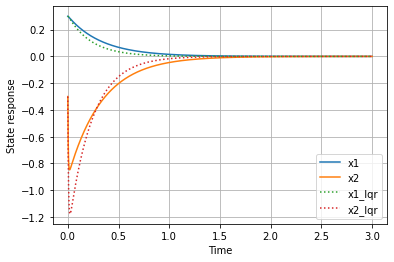

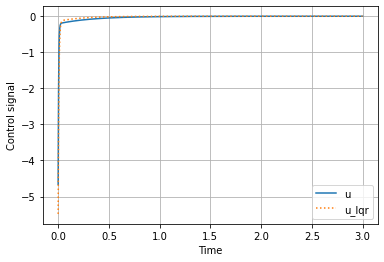

In [10]:
with open('q.txt', 'r') as file: 
    q_learn = file.read() 

x_init = np.array([[0.1,0.1]],dtype=np.float64)

q_learn = q_learn.split()
q_learn = [float(item) for item in q_learn]
q_learn = np.array(q_learn)
u_learn = (q_learn[0]*x_init[0][0] + q_learn[1]*x_init[0][1]) 


n = 2
K = [[q_learn[0], q_learn[1]]]
K_lqr = [[-23.58639732,  -5.31421063]]
x0 = np.array([0.3, -0.3], dtype=np.float64)
u0 = np.matmul(K,x0.T)
u0_lqr = np.matmul(K_lqr,x0.T)
dx = np.array([0,0], dtype=np.float64)

T = 0.001
tf = 3
sam = int(tf / T)
tspan = np.linspace(0, tf, sam + 1)

xs = len(tspan)
x = np.array([x0], dtype=np.float64)
x_lqr = np.array([x0], dtype=np.float64)
u_sig = np.array([u0], dtype=np.float64)
u_sig_lqr = np.array([u0_lqr], dtype=np.float64)

def plant(x, u):
    G = 9.81  # gravity
    l = 0.5   # length of the pole 
    m = 0.15  # ball mass
    b = 0.1   # friction
    dx[0] = x[1]
    dx[1] =  ((m*G*l*np.sin(x[0]) + u - b*x[1]) / (m*l**2))
    return dx

def rk5(x, u, T):
    k1=plant(x,u)*T
    k2=plant(x+k1*0.5,u)*T
    k3=plant(x+k2*0.5,u)*T
    k4=plant(x+k3,u)*T
    dx = x + ((k1+k4)/6+(k2+k3)/3)
    return dx


for i in range(0, xs - 1):
    u = np.matmul(K, x[i].T)
    u_lqr = np.matmul(K_lqr, x_lqr[i].T)

    x_next = rk5(x[i], u, T)
    x_next_lqr = rk5(x_lqr[i], u_lqr, T)
    x = np.vstack((x,x_next))
    x_lqr = np.vstack((x_lqr,x_next_lqr))
    if i >= 1:
        u_sig = np.vstack((u_sig,u))
        u_sig_lqr = np.vstack((u_sig_lqr,u_lqr))

u = np.matmul(K, x[i+1].T)
u_sig = np.vstack((u_sig,u))

u_lqr = np.matmul(K_lqr, x_lqr[i+1].T)
u_sig_lqr = np.vstack((u_sig_lqr,u_lqr))

plt.figure()
plt.plot(tspan, x[:, 0], label="x1")
plt.plot(tspan, x[:, 1], label="x2")
plt.plot(tspan, x_lqr[:, 0], ':',label="x1_lqr")
plt.plot(tspan, x_lqr[:, 1], ':',label="x2_lqr")
plt.grid()
plt.xlabel("Time")
plt.ylabel("State response")
plt.legend()
plt.show()

plt.figure()
plt.plot(tspan, u_sig[:, 0], label="u")
plt.plot(tspan, u_sig_lqr[:, 0],':', label="u_lqr")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Control signal")
plt.legend()

plt.show()




In [12]:

print(x)
import sys

# sys.stdout = open('stdout.txt', 'w')
# for i in range(0,x.size):
#     print(x[i][0],x[i][1])
    
# sys.stdout.close()

# ss = torch.FloatTensor([[1,2,4],[3,4,5]])
# print(ss.t())
# print(ss.size())
# print(ss.t().size())

tensor([[-0.5030, -0.2057],
        [-2.2500,  1.3803],
        [-3.4326, -1.0581],
        ...,
        [-1.8743,  4.6897],
        [-1.8749,  4.6890],
        [-1.8743,  4.6900]])


### Checking result with smaller epsilon ( Lie derivative of V <= epsilon )

In [ ]:
epsilon = -0.00001
start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config, epsilon)
stop_ = timeit.default_timer() 

if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
else:  
    print("Satisfy conditions with epsilon= ",epsilon)
    print(V_learn, " is a Lyapunov function.")
t += (stop_ - start_)

Satisfy conditions with epsilon=  -1e-05
tanh((0.53153824806213379 + 0.41562405228614807 * tanh((-1.1904032230377197 - 0.64355820417404175 * x1 - 0.37806212902069092 * x2)) - 0.52173459529876709 * tanh((-0.87690842151641846 - 0.082122229039669037 * x1 + 0.026046659797430038 * x2)) + 0.94497662782669067 * tanh((-0.7956465482711792 + 0.64431172609329224 * x1 + 0.092067182064056396 * x2)) - 0.80503857135772705 * tanh((1.0789084434509277 + 1.0054492950439453 * x1 + 0.01036079041659832 * x2)) + 1.1105875968933105 * tanh((1.1874630451202393 + 0.036503951996564865 * x1 + 0.0010854984866455197 * x2)) - 0.10321687906980515 * tanh((1.3883064985275269 - 0.080152533948421478 * x1 - 0.48634085059165955 * x2))))  is a Lyapunov function.


### More details on Lyapunov risk
Generally, we start training with Lyapunov risk without the tuning term.      
For example, (1* F.relu(-V_candidate)+ 1.5* F.relu(L_V+0.5)).mean()+ 1.2*(X0).pow(2)    
The weight of each term (1, 1.5, 1.2) can be tuned for balancing each Lyapunov condition.     
Furthermore, using F.relu(L_V+0.5) allows the learning procedure to seek a candidate Lyapunov function with more negative Lie derivative.   
Here 0.5 is also a tunable parameter based on your goal.    
In this example, we use Lyapunov risk with tuning term for achieving large ROA     